In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import dataloader
import modules 
import plots
import utilities
from trainer import Trainer
import torch 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_style import setup_matplotlib_environment, theme_categorical_bright

from IPython.display import display, Markdown


In [3]:
setup_matplotlib_environment()

# Test on Ames House Prices Dataset

## Train a test model

To begin with, we will train a simple model on the Ames House Prices dataset. We will use a simple MLP with a two hidden layers, each with 32 neurons. Since the Ames dataset from Kaggle doesn't have labels in the validation set, we will eventually use a 5-fold cross validation to evaluate the model, but in this initial example let's just see if we can reduce the training error.

In [4]:
ames_house_price_data = dataloader.AmesHouse(batch_size=64)
ames_house_price_data.preprocess()

In [6]:
network_architecture = [32, 32, 8]
model = modules.LinearReLUMLP(network_architecture, learning_rate=0.006, weight_decay=1e-4)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
trainer = Trainer(max_epochs=25, init_random=42)
trainer.fit(model, ames_house_price_data)

Model running on cpu
Epoch 25/25: Train Loss: 0.0108, Val Loss: nan


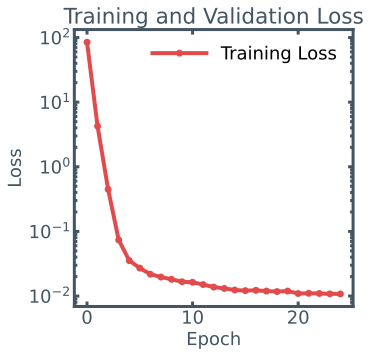

In [8]:
losses = utilities.extract_training_losses(trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')

Text(0, 0.5, 'Predicted Price (USD)')

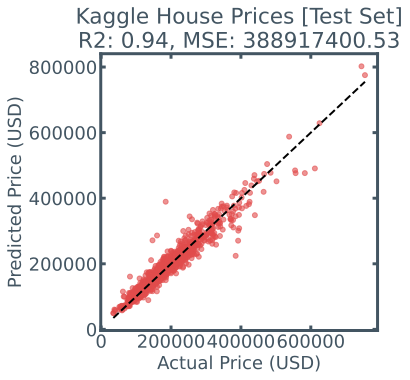

In [9]:
y, y_hat = utilities.get_model_predictions(model, ames_house_price_data, train=True)
fig, ax = plots.correlate_y_vs_yhat(np.exp(y), np.exp(y_hat), title="Kaggle House Prices [Test Set]")
ax.set_xlabel("Actual Price (USD)")
ax.set_ylabel("Predicted Price (USD)")

# K-Fold Cross-Validation

### Why Use K-Fold Cross Validation for the Ames Housing Dataset?

We’re using K-Fold Cross Validation for the Ames Housing dataset because it’s a great way to evaluate our model reliably and avoid overfitting. The official validation set provided in the Kaggle competition for the Ames dataset doesn’t come with labels. This means we can’t directly evaluate our model on it during development. K-Fold Cross Validation helps us simulate this process by splitting our training data into multiple folds for testing.

Additionally, while the Ames Housing dataset is detailed, it’s not huge. K-Fold Cross Validation ensures we use all the data efficiently by training and testing on different subsets. By testing the model on unseen data in each fold, we reduce the risk of overfitting to a single train-test split. 


In [11]:

k = 5
k_fold_datasets = []
k_fold_models = []

for n in range(k):
    k_fold_datasets.append(dataloader.KFoldDataSet.from_dataset(dataset=ames_house_price_data, k=k, n=n))
    k_fold_models.append(modules.LinearReLUMLP(network_architecture, learning_rate=0.006, weight_decay=1e-4))


/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modu

In [12]:
trainers = []

for model, data in zip(k_fold_models, k_fold_datasets):
    trainer = Trainer(max_epochs=25, init_random=42)
    trainer.fit(model, data)
    trainers.append(trainer)

Model running on cpu
Epoch 25/25: Train Loss: 0.0114, Val Loss: 0.0197
Model running on cpu
Epoch 25/25: Train Loss: 0.0117, Val Loss: 0.0265
Model running on cpu
Epoch 25/25: Train Loss: 0.0083, Val Loss: 0.02290
Model running on cpu
Epoch 25/25: Train Loss: 0.0120, Val Loss: 0.0156
Model running on cpu
Epoch 25/25: Train Loss: 0.0114, Val Loss: 0.0411


## Model Trained on cross-validation set 1/5

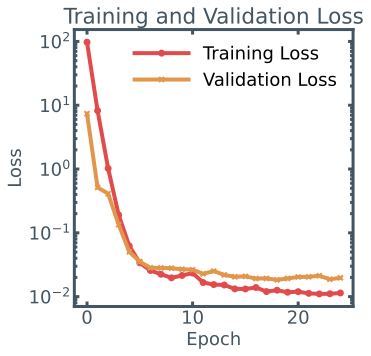

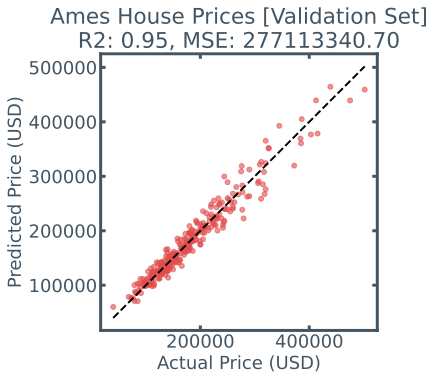

## Model Trained on cross-validation set 2/5

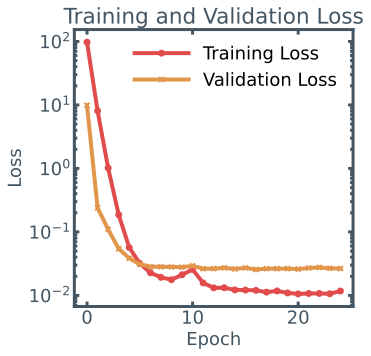

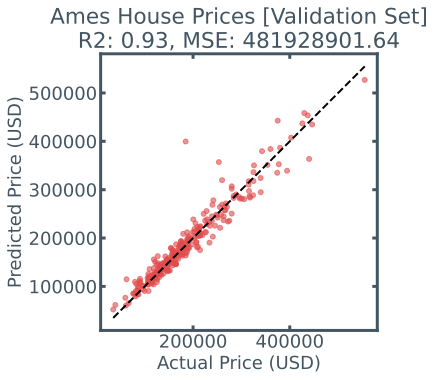

## Model Trained on cross-validation set 3/5

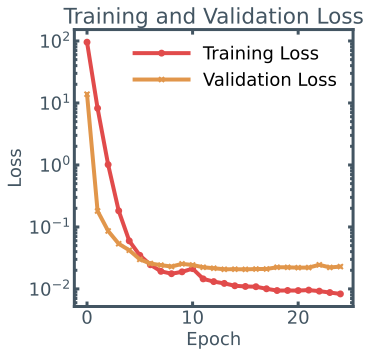

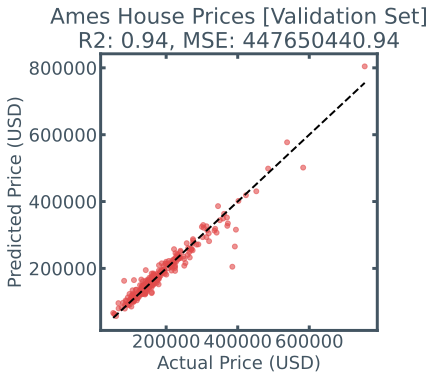

## Model Trained on cross-validation set 4/5

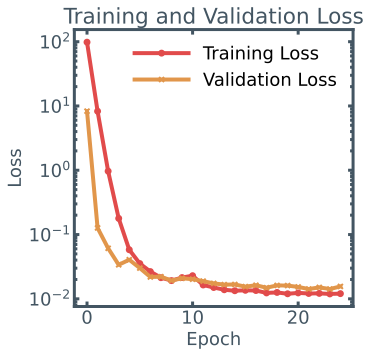

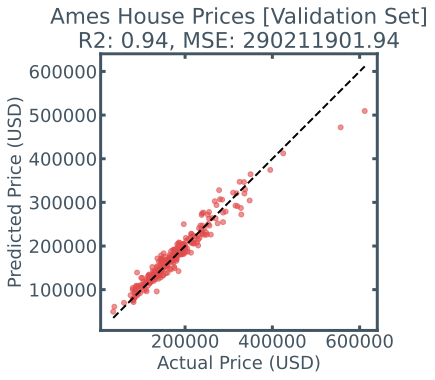

## Model Trained on cross-validation set 5/5

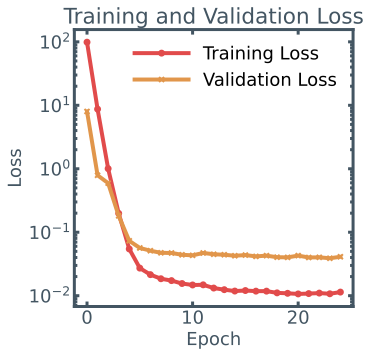

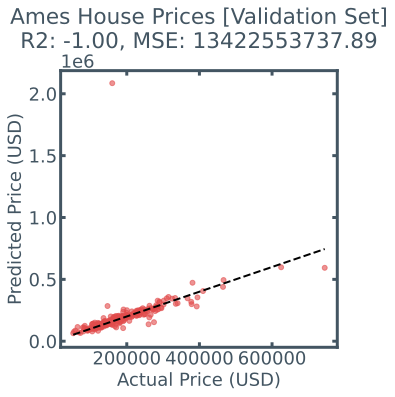

In [14]:
for i, trainer in enumerate(trainers):
    display(Markdown(f"## Model Trained on cross-validation set {i+1}/{k}"))

    losses = utilities.extract_training_losses(trainer.metadata)
    fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
    ax.set_yscale("log")
    y, y_hat = utilities.get_model_predictions(model, k_fold_datasets[i], train=False)
    fig, ax = plots.correlate_y_vs_yhat(np.exp(y), np.exp(y_hat), title="Ames House Prices [Validation Set]")
    ax.set_xlabel("Actual Price (USD)")
    ax.set_ylabel("Predicted Price (USD)")
    plt.show()
